# LUCAS Dataset imbalanced class prediction problem
## TODO:
- Run Models with different parameters for all different dates in sepparate
- Find way to make random variable transformations
- Test using float features

In [305]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.decomposition import PCA
#from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier#, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC#, SVC
from sklearn.feature_selection import RFE, RFECV#, SelectFromModel, SelectKBest, chi2

from sklearnext.tools import report_model_search_results
from sklearnext.over_sampling import SMOTE, GeometricSMOTE, RandomOverSampler, DensityDistributor
from sklearnext.model_selection import ModelSearchCV
from sklearnext.cluster import KMeans, SOM, AgglomerativeClustering, Birch, SpectralClustering

from imblearn.pipeline import Pipeline

import datetime as dt # used for convenience purposes

%config InlineBackend.figure_format = 'retina'






correlation_threshold = 0.9

In [360]:
df = pd.read_csv('../data/raw/tabexport2.csv', delimiter=';')

new_columns = {}
for col in df.columns[1:]:
    new_columns[col] = (col.replace('LC08_L1TP_204032_2015', '')[:4]+'_band'+col[-1:])#[1:]
df = df.rename(columns=new_columns)
df.to_csv('../data/interim/data.csv', index=False)

In [3]:
df.groupby('class').size()

class
A    131
B    270
C    761
D    296
E    185
F     37
G     10
H      4
dtype: int64

![class labels](https://ec.europa.eu/eurostat/statistics-explained/images/9/99/LUCAS_-_classification_of_land_cover.png)

In [4]:
# Degree of Dimensionality
DoD = lambda sample_size, features: sample_size/features
ft = len(df.columns)-1 # -1 is used to disregard the column "class"
df.groupby('class').size().apply(lambda sample_size: DoD(sample_size, ft))

class
A     2.729167
B     5.625000
C    15.854167
D     6.166667
E     3.854167
F     0.770833
G     0.208333
H     0.083333
dtype: float64

In [5]:
# Imbalance Ratio
IR = lambda majority_class, class_label: majority_class/class_label
majority_class = df.groupby('class').size().max()
df.groupby('class').size().apply(lambda class_size: IR(majority_class, class_size))

class
A      5.809160
B      2.818519
C      1.000000
D      2.570946
E      4.113514
F     20.567568
G     76.100000
H    190.250000
dtype: float64

In [6]:
report = pandas_profiling.ProfileReport(df, correlation_threshold=correlation_threshold)
report

Number of variables,49
Number of observations,1694
Total Missing (%),0.0%
Total size in memory,648.6 KiB
Average record size in memory,392.0 B
Numeric,16
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,32


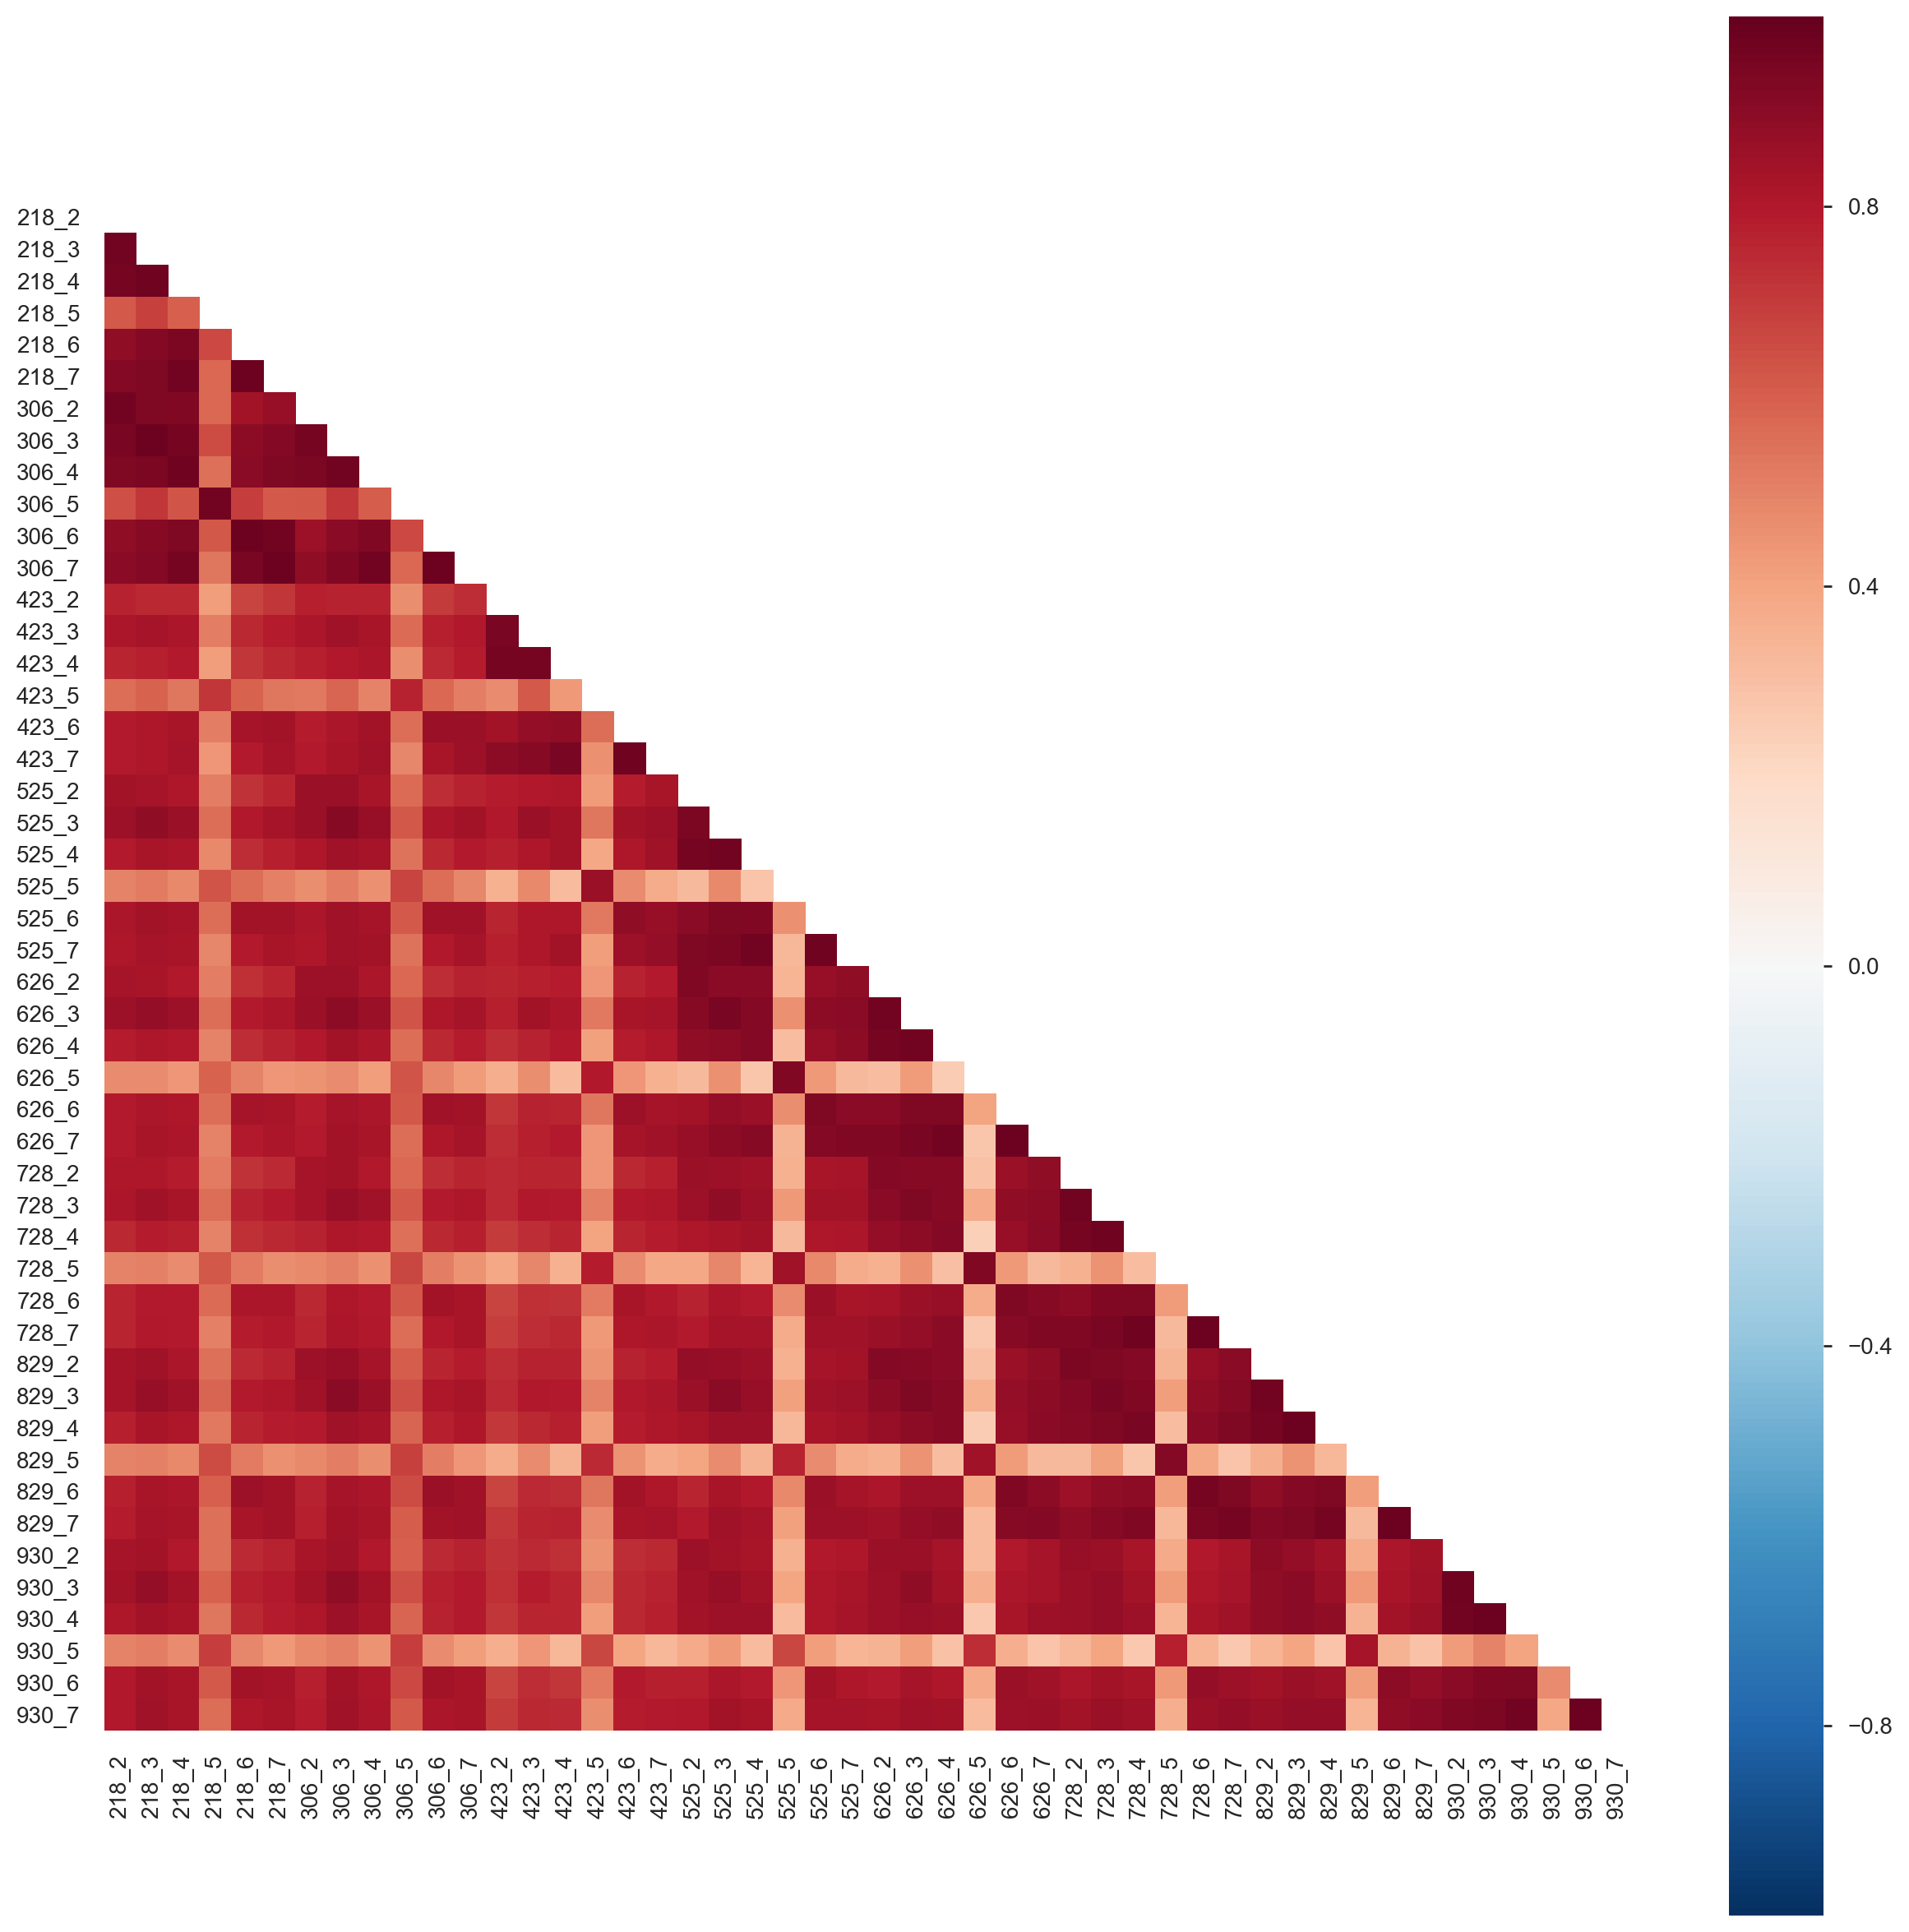

In [7]:
def make_corr_table(df, method='spearman', fig_size=(15,15)):
    corr = df.corr(method=method)
    # remove the upper diagonal of the correlation matrix
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        fig, ax = plt.subplots()
        fig.set_size_inches(fig_size[0], fig_size[1])
        sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, square=True, ax=ax, cmap='RdBu_r')
    
    
make_corr_table(df)

## Preprocessing stage
- Take highly correlated variable pairs (threshold ρ=0.9)
- Standardize them
- Run PCA on transformed variables
- Keep as many features as necessary such that the minimum explained variability criteria is met

**Note**: Which other features can we extract from this?

Selecting only one of the days and attempt to transform the variables with relatively random calculations

In [200]:
# Dropping extremely rare classes
#obs_lost_percentage = df[df['class'].isin(['F', 'G', 'H'])].groupby('class').size().sum() / df.groupby('class').size().sum()
#df2 = df[~df['class'].isin(['F', 'G', 'H'])]
#print('Dropped {0:.2f}% of total observations.'.format(obs_lost_percentage*100))

# Selecting a specific day
day_vars = []
for col in df.columns:
    if col.startswith('218'):
        day_vars.append(col)

df2 = df[['class']+day_vars]

X = df2.drop(columns='class')
y = df2['class']

# creating new variables
# (required for logs) min-max standardization
scaler = MinMaxScaler(feature_range=(0.1, 10), copy=True)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# logs
logs = X.apply(np.log) # logarithm of base e
logs.columns = ['(log_'+i+')' for i in X.columns]
# e^x
exps = X.apply(np.exp) # e^x
exps.columns = ['(exp_'+i+')' for i in X.columns]
# squared variables
sqrd = X.apply(lambda i: i**2)
sqrd.columns = ['('+i+'**2)' for i in X.columns]

X2 = pd.concat([X, logs, exps, sqrd], axis=1)
cols = list(X2.columns)

# sums, multiplications
for i1 in cols:
    for i2 in cols:
        # sums
        X2[f'({i1}+{i2})'] = X2[i1] + X2[i2]
        # multiplications
        X2[f'({i1}*{i2})'] = X2[i1] * X2[i2]
        # divisions
        X2[f'({i1}/{i2})'] = X2[i1] / X2[i2]

X2 = X2.loc[:, (X2!=1).all()].replace([np.inf, -np.inf], np.nan).dropna(axis=1) # 1694 rows × 1670 columns

# Should reject highly correlated variables here
df_corr = X2.corr() #> correlation_threshold
df_corr = pd.DataFrame(np.tril(df_corr), columns=df_corr.columns, index=df_corr.index)
np.fill_diagonal(df_corr.values, 0)

id_0, id_1 = np.where(df_corr>correlation_threshold)
rejected_vars = np.array(df_corr.index)[np.unique(id_0)]

X3 = X2.drop(columns=rejected_vars)

""" One method, although I don't know exactly what's happening here """
#lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X2, y)
#model = SelectFromModel(lsvc, prefit=True)
#X_new = model.transform(X2)
#X_new.shape


""" Univariate testing: perform a chi-square test to the samples to retrieve only the two best features """
#scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
#_X2 = pd.DataFrame(scaler.fit_transform(X2), columns=X2.columns)

#kbest = SelectKBest(chi2, k=48)
#kbest.fit_transform(_X2, y)
#selected_columns = np.array(X2.columns)[kbest.get_support()]

#X_final = X2[selected_columns]

""" Recursive Feature Extraction """
# CV version
lr = LogisticRegression(max_iter=20000, solver='lbfgs', multi_class='auto')
# step may need to be better adjusted, check later
selector = RFECV(lr, step=0.1, min_features_to_select=6, cv=5, verbose=1)
selector = selector.fit(X3, y)

final_cols    = np.array(X3.columns)[selector.ranking_==1]
rejected_cols = np.concatenate([np.array(X3.columns)[selector.ranking_!=1], rejected_vars])

X_final    = X2[final_cols]
X_rejected = X2[rejected_cols]

make_corr_table(X_final)

In [290]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.1)

# question: Is it a good idea to make additional PCA on other variables with high correlation?
X_train_final    = X_train[final_cols]
X_train_rejected = X_train.loc[:,rejected_cols]

X_test_final    = X_test[final_cols]
X_test_rejected = X_test.loc[:,rejected_cols]

# standardize highly correlated data
sc = StandardScaler()
X_train_rejected[X_train_rejected.columns] = sc.fit_transform(X_train_rejected)
X_test_rejected[X_test_rejected.columns] = sc.transform(X_test_rejected)

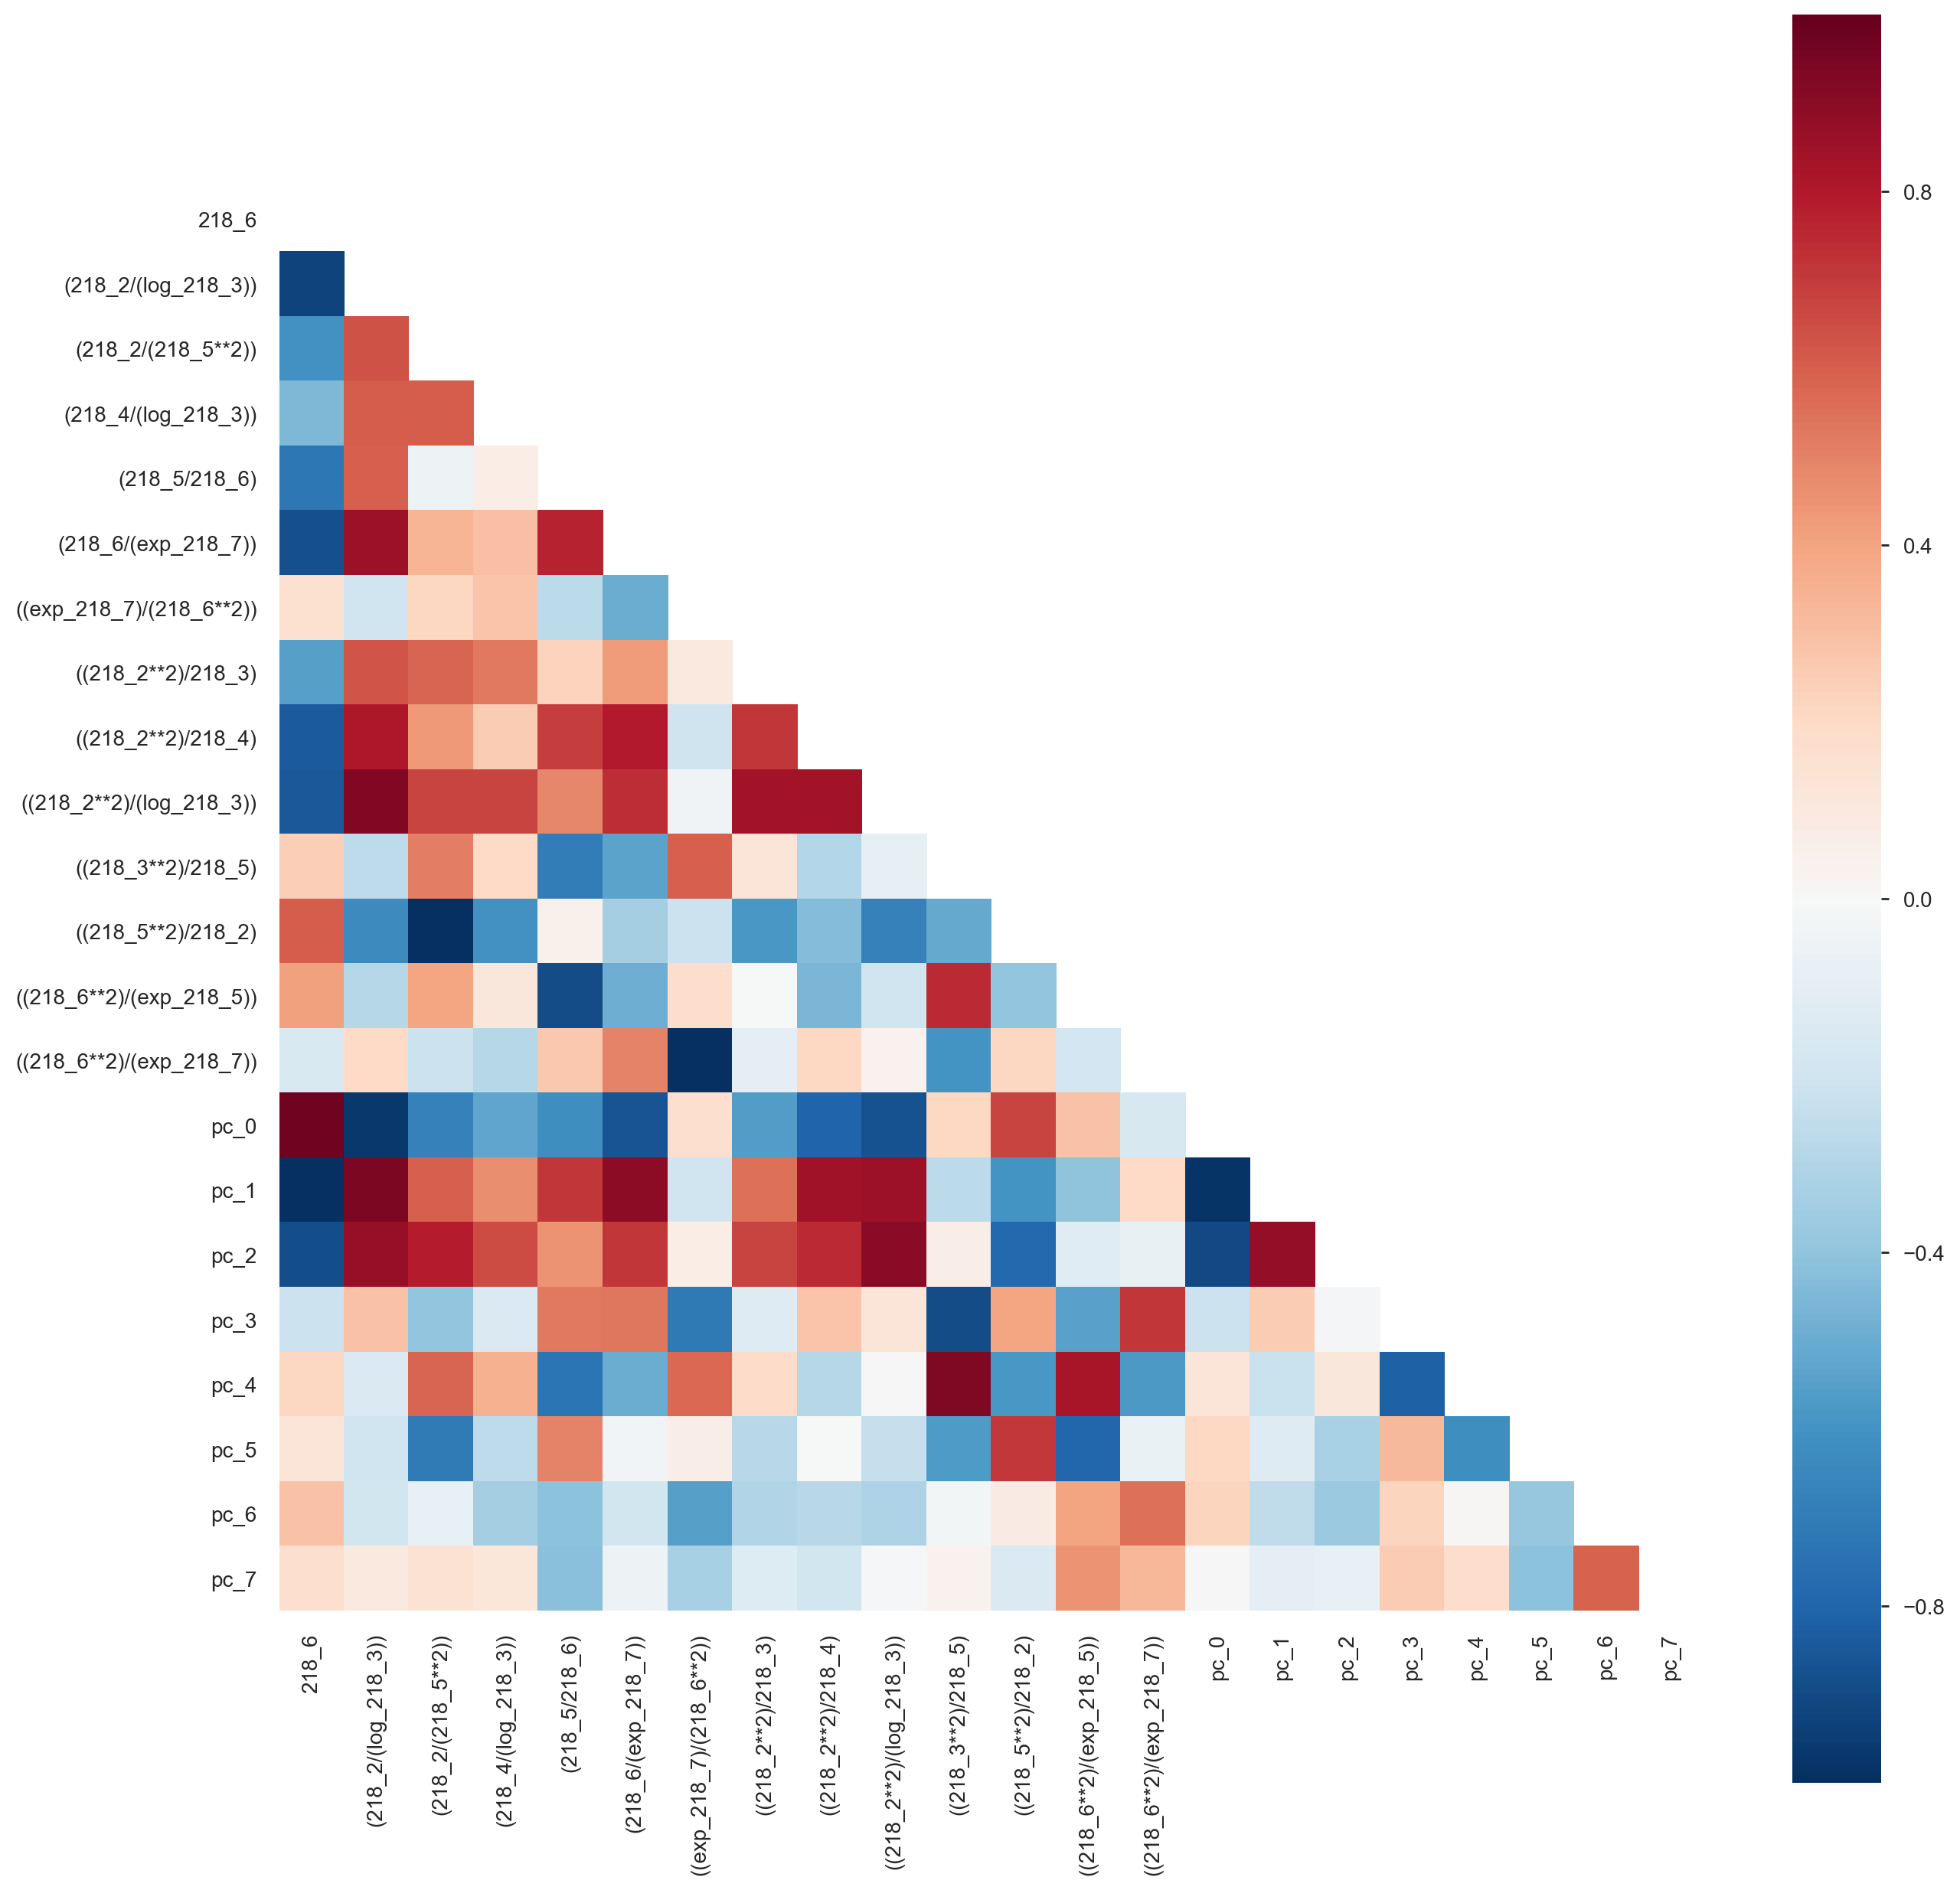

In [289]:
# Running PCA

min_var = 0.95

old_cols = list(X_train_rejected.columns)

# Run PCA on standardized data
pca = PCA()
train_rejected = pca.fit_transform(X_train_rejected)
test_rejected = pca.transform(X_test_rejected)

# % of explained variance for each additional feature
np.cumsum(pca.explained_variance_ratio_)
# Get column name for the principal components' tables
pc_cols  = [f'pc_{i}' for i in range(np.where(np.cumsum(pca.explained_variance_ratio_) > min_var)[0][0])]
# Number of features to keep to get {min_var}% of explained variability
for i in range(np.where(np.cumsum(pca.explained_variance_ratio_) > min_var)[0][0]):
    X_train_rejected[f'pc_{i}'] = train_rejected[:,i]
    X_test_rejected[f'pc_{i}']  = test_rejected[:,i]

# build final dataset
X_train_final = X_train_final.join(X_train_rejected[pc_cols], on=None, how='outer')
X_test_final  = X_test_final.join(X_test_rejected[pc_cols])
make_corr_table(X_train_final)

## Modelling (original model search function)

In [335]:
def model_search(X, y, approach='standard'):
    """
    Function built for convenience purposes. oversamplers, classifiers etc etc must be edited in the function itself,
    if necessary.
    """
    global oversamplers, classifiers, grid, param_grids, estimators
    
    configs = {
        'scoring': ['f1_weighted', 'geometric_mean_score', 'accuracy'],
        'n_splits': 5,
        'n_runs': 3,
        'random_state': 0,
        'n_jobs': -1,
        'verbose':1
    }
    # original scoring: ['f1_weighted', 'geometric_mean_score', 'accuracy']
    
    oversamplers = [
        ('none', None),
        ('RandomOverSampler', RandomOverSampler()),
        ('smote', SMOTE()),
        ('gsmote', GeometricSMOTE())
    ]

    classifiers = [
        ('GBC', GradientBoostingClassifier()),
        ('DT', DecisionTreeClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('LR', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1e4)),
        #('RF', RandomForestClassifier()) # not on the G-SMOTE paper
    ]


    grid = {
        'smote': {'k_neighbors': [2, 3, 4, 5]},
        'gsmote': {
            'k_neighbors': [2, 3, 4, 5],
            'truncation_factor': [-1.0, -0.5, .0, 0.25, 0.5, 0.75, 1.0], 
            'deformation_factor': [.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0],
            'selection_strategy': ['combined', 'minority', 'majority']
        },
        'DT':{'max_depth': [3, 6]},
        'KNN':{'n_neighbors':[3,4,5,6,7]},
        'GBC':{
            'max_depth': [3, 6], 
            'n_estimators': [50, 100]
        }
    }

    param_grids = []
    estimators = []
    
    for oversampler in oversamplers:
        for classifier in classifiers:

            # sets up pipeline with name
            name = f'{oversampler[0]}+{classifier[0]}'
            if approach == 'standard':
                estimators.append((name, Pipeline([oversampler, classifier])))
            elif approach == 'onevsrest':
                estimators.append((name, OneVsRestClassifier(Pipeline([oversampler, classifier]))))
            elif approach == 'onevsone':
                estimators.append((name, OneVsOneClassifier(Pipeline([oversampler, classifier]))))
                

            # sets up param grid for the estimator
            param_grid = {}
            if oversampler[0] in grid.keys(): 
                for key, value in grid[oversampler[0]].items():
                    if approach == 'standard':
                        param_grid[f'{name}__{oversampler[0]}__{key}'] = value
                    elif approach in ['onevsrest', 'onevsone']:
                        param_grid[f'{name}__estimator__{oversampler[0]}__{key}'] = value

            if classifier[0]  in grid.keys(): 
                for key, value in grid[classifier[0]].items():
                    if approach == 'standard':
                        param_grid[f'{name}__{classifier[0]}__{key}'] = value
                    elif approach in ['onevsrest', 'onevsone']:
                        param_grid[f'{name}__estimator__{classifier[0]}__{key}'] = value
            if len(param_grid)>0:
                param_grids.append(param_grid)


    model_search_cv = ModelSearchCV(
        estimators=estimators, 
        param_grids=param_grids, 
        scoring=configs['scoring'], 
        cv=StratifiedKFold(n_splits=configs['n_splits'], shuffle=True),
        refit=False, 
        n_jobs=configs['n_jobs'],
        verbose=configs['verbose']
    )

    model_search_cv.fit(X, y)

    return model_search_cv

### Standard Approach

In [336]:
print('[%s]' % dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
model_search_cv = model_search(X_train_final, y_train, approach='standard')
report_model_search_results(model_search_cv).sort_values('mean_test_f1_weighted', ascending=False)

[2019-06-15 16:32:09]
Fitting 5 folds for each of 7128 candidates, totalling 35640 fits


/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 63.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 86.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 133.0min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 18

,models,params,mean_fit_time,mean_test_f1_weighted,mean_test_geometric_mean_score,mean_test_accuracy
1340,gsmote+GBC,"{'GBC__max_depth': 6, 'GBC__n_estimators': 50,...",12.086260,0.548483,0.0,0.542651
728,gsmote+GBC,"{'GBC__max_depth': 3, 'GBC__n_estimators': 100...",12.347077,0.547672,0.0,0.551181
1320,gsmote+GBC,"{'GBC__max_depth': 6, 'GBC__n_estimators': 50,...",11.722773,0.546928,0.0,0.549869
99,gsmote+GBC,"{'GBC__max_depth': 3, 'GBC__n_estimators': 50,...",5.322837,0.546671,0.0,0.541995
1658,gsmote+GBC,"{'GBC__max_depth': 6, 'GBC__n_estimators': 50,...",11.558248,0.545531,0.0,0.535433
875,gsmote+GBC,"{'GBC__max_depth': 3, 'GBC__n_estimators': 100...",10.277797,0.545094,0.0,0.536745
858,gsmote+GBC,"{'GBC__max_depth': 3, 'GBC__n_estimators': 100...",13.081353,0.544879,0.0,0.533465
690,gsmote+GBC,"{'GBC__max_depth': 3, 'GBC__n_estimators': 100...",20.801509,0.544221,0.0,0.543307
2077,gsmote+GBC,"{'GBC__max_depth': 6, 'GBC__n_estimators': 100...",22.613406,0.544024,0.0,0.538714
1857,gsmote+GBC,"{'GBC__max_depth': 6, 'GBC__n_estimators': 100...",22.132042,0.543966,0.0,0.535433


### One-vs-rest approach

In [295]:
print('[%s]' % dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
model_search_cv_OVR = model_search(X_train_final, y_train, approach='onevsrest')
report_model_search_results(model_search_cv_OVR).sort_values('mean_test_f1_weighted', ascending=False)

[2019-06-15 02:29:42]
Fitting 5 folds for each of 588 candidates, totalling 2940 fits


/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed: 31.4min finished


,models,params,mean_fit_time,mean_test_f1_weighted,mean_test_geometric_mean_score,mean_test_accuracy
543,gsmote+RF,"{'estimator__RF__n_estimators': 100, 'estimato...",5.695272,0.543436,0.000000,0.540026
467,gsmote+RF,"{'estimator__RF__n_estimators': 50, 'estimator...",3.401258,0.542349,0.000000,0.539370
477,gsmote+RF,"{'estimator__RF__n_estimators': 50, 'estimator...",3.497448,0.541968,0.000000,0.537402
472,gsmote+RF,"{'estimator__RF__n_estimators': 50, 'estimator...",3.476190,0.541900,0.000000,0.539370
507,gsmote+RF,"{'estimator__RF__n_estimators': 70, 'estimator...",4.266295,0.541783,0.000000,0.538058
402,gsmote+RF,"{'estimator__RF__n_estimators': 10, 'estimator...",1.581148,0.541142,0.000000,0.536745
540,gsmote+RF,"{'estimator__RF__n_estimators': 100, 'estimato...",5.650777,0.540614,0.000000,0.536089
514,gsmote+RF,"{'estimator__RF__n_estimators': 100, 'estimato...",5.794800,0.540430,0.000000,0.532808
523,gsmote+RF,"{'estimator__RF__n_estimators': 100, 'estimato...",5.812121,0.540235,0.000000,0.532152
23,RandomOverSampler+RF,{'estimator__RF__n_estimators': 50},1.680299,0.540146,0.000000,0.555118


### One-vs-One approach

In [296]:
print('[%s]' % dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
model_search_cv_OVO = model_search(X_train_final, y_train, approach='onevsone')
report_model_search_results(model_search_cv_OVO).sort_values('mean_test_f1_weighted', ascending=False)

/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[2019-06-15 03:01:07]
Fitting 5 folds for each of 588 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 59.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 76.6min
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed: 95.1min finished


,models,params,mean_fit_time,mean_test_f1_weighted,mean_test_geometric_mean_score,mean_test_accuracy
11,none+RF,{'estimator__RF__n_estimators': 70},3.228122,0.541293,0.000000,0.567585
75,smote+RF,"{'estimator__RF__n_estimators': 100, 'estimato...",5.731306,0.535276,0.000000,0.527559
9,none+RF,{'estimator__RF__n_estimators': 30},1.449785,0.535200,0.000000,0.562336
22,RandomOverSampler+RF,{'estimator__RF__n_estimators': 30},1.666720,0.533316,0.000000,0.541995
12,none+RF,{'estimator__RF__n_estimators': 100},4.661783,0.532718,0.000000,0.559055
385,gsmote+RF,"{'estimator__RF__n_estimators': 10, 'estimator...",1.459031,0.530417,0.000000,0.519029
66,smote+RF,"{'estimator__RF__n_estimators': 50, 'estimator...",2.890092,0.530033,0.000000,0.524934
471,gsmote+RF,"{'estimator__RF__n_estimators': 50, 'estimator...",3.622237,0.529255,0.000000,0.518373
540,gsmote+RF,"{'estimator__RF__n_estimators': 100, 'estimato...",6.370583,0.528563,0.000000,0.518373
25,RandomOverSampler+RF,{'estimator__RF__n_estimators': 100},5.019026,0.527824,0.000000,0.537402


## Modelling part 2
### Applying Normalization

In [297]:
norms = {'ss':StandardScaler(), 'l1':Normalizer(norm='l1'), 'l2':Normalizer(norm='l2')}
scores = {}

for norm_name, norm_func in norms.items():
    print(f'Testing with {norm_name} normalization.')
    norm_X_train_final = norm_func.fit_transform(X_train_final)
    
    print('[%s] Model searching using standard approach' % dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    norm_model_search_cv = model_search(norm_X_train_final, y_train, approach='standard')
    scores[f'{norm_name}+standard'] = report_model_search_results(norm_model_search_cv).sort_values('mean_test_f1_weighted', ascending=False)
    print('[%s] Model searching using one vs rest approach' % dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    norm_model_search_cv = model_search(norm_X_train_final, y_train, approach='onevsrest')
    scores[f'{norm_name}+onevsrest'] = report_model_search_results(norm_model_search_cv).sort_values('mean_test_f1_weighted', ascending=False)
    print('[%s] Model searching using one vs one approach' % dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    norm_model_search_cv = model_search(norm_X_train_final, y_train, approach='onevsone')
    scores[f'{norm_name}+onevsone'] = report_model_search_results(norm_model_search_cv).sort_values('mean_test_f1_weighted', ascending=False)
    

/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Testing with ss normalization.
[2019-06-15 04:36:11] Model searching using standard approach
Fitting 5 folds for each of 588 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 842 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1292 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1842 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 2492 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed: 13.3min finished
/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[2019-06-15 04:49:31] Model searching using one vs rest approach
Fitting 5 folds for each of 588 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1806 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 2456 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed: 33.3min finished
/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[2019-06-15 05:22:48] Model searching using one vs one approach
Fitting 5 folds for each of 588 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 61.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 77.7min
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed: 94.4min finished
/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Testing with l1 normalization.
[2019-06-15 06:57:12] Model searching using standard approach
Fitting 5 folds for each of 588 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 872 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1322 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1872 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2522 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed: 12.0min finished
/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[2019-06-15 07:09:14] Model searching using one vs rest approach
Fitting 5 folds for each of 588 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed: 28.9min finished
/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[2019-06-15 07:38:09] Model searching using one vs one approach
Fitting 5 folds for each of 588 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 71.1min
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed: 87.6min finished
/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Testing with l2 normalization.
[2019-06-15 09:05:45] Model searching using standard approach
Fitting 5 folds for each of 588 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 247 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 847 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1297 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1847 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2497 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed: 12.4min finished
/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[2019-06-15 09:18:09] Model searching using one vs rest approach
Fitting 5 folds for each of 588 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed: 29.2min finished
/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[2019-06-15 09:47:21] Model searching using one vs one approach
Fitting 5 folds for each of 588 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 55.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 70.8min
[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed: 87.4min finished


In [492]:
for key, df in scores.items():
    print(f'{key}:\t %s' % df['mean_test_f1_weighted'].max())


ss+standard:	 0.5316264761014766
ss+onevsrest:	 0.5464925568565908
ss+onevsone:	 0.5530907168208162
l1+standard:	 0.5286169208567506
l1+onevsrest:	 0.5324352254613431
l1+onevsone:	 0.5390866298139035
l2+standard:	 0.5295668052640905
l2+onevsrest:	 0.5283125557770837
l2+onevsone:	 0.5329729336432031


## Creating proper configurations for running the experiments

It's been observed from the previous experiments that using a mix of **Standard Scaling** and **One-vs-One**/**One-vs-Rest** provide optimal results, which should make it possible to run models as binary experiments **(?)**

### Adapting configurations
https://github.com/IMS-ML-Lab/publications/blob/master/scripts/config.py

In [334]:
ORIGINAL_CONFIGURATIONS = {
    'oversamplers': [
        ('NO OVERSAMPLING', None),
        ('RANDOM OVERSAMPLING', RandomOverSampler()),
        ('SMOTE', SMOTE(), {'k_neighbors': [3, 5]}),
        ('G-SMOTE', GeometricSMOTE(), {'selection_strategy': ['combined', 'minority', 'majority'], 'k_neighbors': [3, 5], 'truncation_factor': [-1.0, -0.5, .0, 0.25, 0.5, 0.75, 1.0], 'deformation_factor': [.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]})
    ],
    'classifiers': [
        ('LR', LogisticRegression(solver='lbfgs', max_iter=1e4)),
        ('KNN', KNeighborsClassifier(), {'n_neighbors': [3, 5]}),
        ('DT', DecisionTreeClassifier(), {'max_depth': [3, 6]}),
        ('GBC', GradientBoostingClassifier(), {'max_depth': [3, 6], 'n_estimators': [50, 100]})
    ],
    #'scoring': ['roc_auc', 'f1', 'geometric_mean_score'],
    'scoring': ['f1_weighted', 'geometric_mean_score', 'accuracy'],
    'n_splits': 5,
    'n_runs': 3,
    'random_state': 0
}

NEW_CONFIGURATIONS = {
    'oversamplers': [
        ('NO OVERSAMPLING', None),
        ('RANDOM OVERSAMPLING', RandomOverSampler()),
        ('SMOTE', SMOTE(), {'k_neighbors': [3, 5]}),
        ('G-SMOTE', GeometricSMOTE(), {'selection_strategy': ['combined', 'minority', 'majority'], 'k_neighbors': [3, 5], 'truncation_factor': [-1.0, -0.5, .0, 0.25, 0.5, 0.75, 1.0], 'deformation_factor': [.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]})
    ],
    'classifiers': [
        ('LR', OneVsOneClassifier(LogisticRegression(solver='lbfgs', max_iter=1e4))),
        ('KNN', OneVsOneClassifier(KNeighborsClassifier()), {'n_neighbors': [3, 5]}),
        ('DT', OneVsOneClassifier(DecisionTreeClassifier()), {'max_depth': [3, 6]}),
        ('GBC', OneVsOneClassifier(GradientBoostingClassifier()), {'max_depth': [3, 6], 'n_estimators': [50, 100]})
    ],
    'scoring': ['roc_auc', 'f1', 'geometric_mean_score'],
    'n_splits': 5,
    'n_runs': 3,
    'random_state': 0
}


from sklearnext.tools import BinaryExperiment

stdscaler = StandardScaler()
norm_X_train_final = stdscaler.fit_transform(X_train_final)

datasets = [
    ('day_', (norm_X_train_final, y_train)),
    
]

n_jobs=-1
verbose=1
name='ovo experiment'

experiment = BinaryExperiment(name, datasets, NEW_CONFIGURATIONS['oversamplers'], NEW_CONFIGURATIONS['classifiers'], NEW_CONFIGURATIONS['scoring'], NEW_CONFIGURATIONS['n_splits'], NEW_CONFIGURATIONS['n_runs'], NEW_CONFIGURATIONS['random_state'])
experiment.run(n_jobs=n_jobs, verbose=verbose)
experiment.summarize_datasets()
experiment.calculate_optimal()
experiment.calculate_wide_optimal()
experiment.calculate_ranking()
experiment.calculate_mean_sem_ranking()
experiment.calculate_mean_sem_scores()
experiment.calculate_mean_sem_perc_diff_scores()
experiment.calculate_friedman_test()
experiment.calculate_holms_test()
experiment.dump(experiment_path)



Fitting 5 folds for each of 8046 candidates, totalling 40230 fits


/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: multiclass format is not supported

In [ ]:
def model_search(X, y, configs, approach='standard'):
    """
    Function built for convenience purposes. oversamplers, classifiers etc etc must be edited in the function itself,
    if necessary.
    """
    global oversamplers, classifiers, grid, param_grids, estimators


    model_search_cv = ModelSearchCV(
        estimators=estimators, 
        param_grids=param_grids, 
        scoring=['f1_weighted', 'geometric_mean_score', 'accuracy'], 
        cv=StratifiedKFold(n_splits=5, shuffle=True),
        refit=False, 
        n_jobs=-1,
        verbose=1
    )

    model_search_cv.fit(X, y)

    return model_search_cv

In [315]:
CONFIGURATIONS['GSMOTE'].keys()


# model name -> ['oversamplers', 'classifiers', 'scoring', 'n_splits', 'n_runs', 'random_state']

dict_keys(['oversamplers', 'classifiers', 'scoring', 'n_splits', 'n_runs', 'random_state'])

# TEMPORARY AREA

In [490]:
import sqlite3

df = pd.read_csv('../data/interim/data.csv', delimiter=',')
cols = list(df.columns)
cols.remove('class')
cols = cols + ['class']
cols

conn = sqlite3.connect('../data/raw/remote_sensing_data.db')
#query = "SELECT country FROM Population WHERE population > 50000000;"

lucas = pd.read_sql_query('SELECT * FROM lucas', conn)
lucas.columns = cols

# Create sqlite database and cursor
conn = sqlite3.connect('../data/interim/remote_sensing_data.db')
c = conn.cursor()


dfs = {}
days = set([col.split('_band')[0] for col in cols])
bands = [f'band{i}' for i in range(2,8)] + ['class']
days.remove('class')

for day in days:
    day_cols = []
    for col in cols:
        if day in col:
            day_cols.append(col)
    dfs[day] = lucas[day_cols+['class']]
    dfs[day]['day'] = day
    dfs[day] = dfs[day][[list(dfs[day].columns)[-1]] + list(dfs[day].columns)[:-1]]
    dfs[day] = dfs[day].reset_index().rename(columns={'index':'pixel_id'})
    dfs[day].columns = ['pixel_id','day']+bands

ready_df = pd.concat(list(dfs.values())).set_index('pixel_id')
ready_df.to_sql('lucas', conn, if_exists='fail', index=True)


#col_exec = ''
#for col in cols:
#    if col not in ['class', 'day']:
#        col_exec+=f'\n            \'{col}\' NUM,'
#    else:
#        col_exec+=f'\n            \'{col}\' TEXT,'

#col_exec = col_exec[:-1]

#c.execute(f"""CREATE TABLE IF NOT EXISTS lucas (
#            id INTEGER PRIMARY KEY,
#            {col_exec}
#            )""")


#conn.commit()


/Users/jfonseca/.conda/envs/datascience/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [494]:
ready_df['day'].unique()

array(['0626', '0218', '0829', '0423', '0306', '0525', '0930', '0728'],
      dtype=object)

In [497]:
ready_df.shape[0] / 8


1694.0

In [502]:
ready_df.dtypes

day      object
band2     int64
band3     int64
band4     int64
band5     int64
band6     int64
band7     int64
class    object
dtype: object